### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from keras.models import Model
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### Load Dataset and split data

In [2]:
cifar10 = datasets.cifar10 
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog','frog', 'horse', 'ship', 'truck']

### Save validation data

In [3]:
train_images, train_labels = train_images[5000:], train_labels[5000:]
validation_images, validation_labels = train_images[:5000], train_labels[:5000]

### Store in TensorFlow Dataset representation

In [4]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

### Plot images

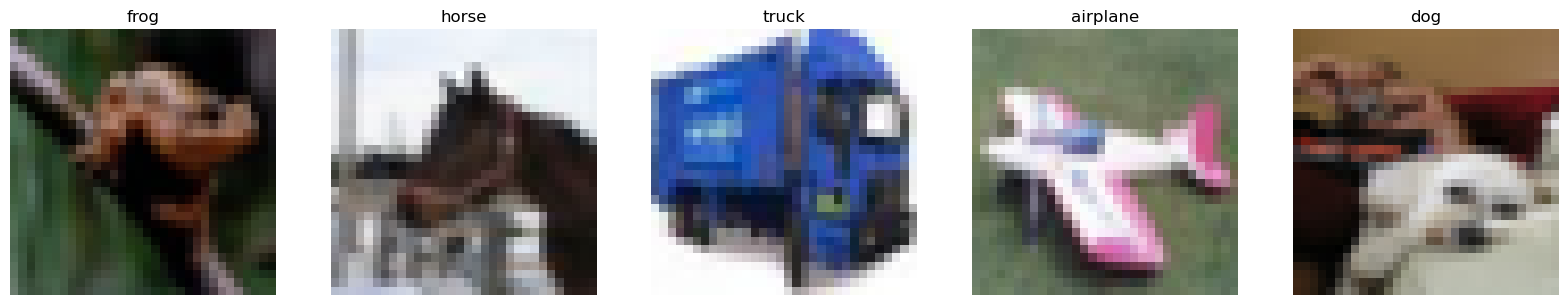

In [5]:
plt.figure(figsize=(20,20))
for i, (image, label) in enumerate(train_ds.take(5)):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label.numpy()[0]])
    plt.axis('off')

### Preprocess Data

In [6]:
def process_images(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    return image, label

In [7]:
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
validation_ds_size = tf.data.experimental.cardinality(validation_ds).numpy()
print("Training data size:", train_ds_size)
print("Test data size:", test_ds_size)
print("Validation data size:", validation_ds_size)

Training data size: 45000
Test data size: 10000
Validation data size: 5000


### * Apply Preprocessing
### * Shuffle Dataset
### * Batch data

In [8]:
train_ds = (train_ds
            .map(process_images)
            .shuffle(buffer_size=1000)
            .batch(batch_size=256, drop_remainder=True))
                   
test_ds = (test_ds
           .map(process_images)
           .shuffle(buffer_size=1000)
           .batch(batch_size=256, drop_remainder=True))
                   
validation_ds = (validation_ds
                 .map(process_images)
                 .shuffle(buffer_size=1000)
                 .batch(batch_size=256, drop_remainder=True))

### Implement Model

In [9]:
def VGG16(classes=10):
# Uncomment layers as requirements and available resources
    
    img_input = Input(shape=(32, 32, 3)) 
    x = Conv2D(64,(3,3),padding='same',activation = 'relu')(img_input)
    x = Conv2D(64,(3,3),padding='same',activation = 'relu')(x)
    x = MaxPooling2D((2,2),strides=(2,2))(x)

    x = Conv2D(128,(3,3),padding='same',activation = 'relu')(x)
    x = Conv2D(128,(3,3),padding='same',activation = 'relu')(x)
    x = MaxPooling2D((2,2),strides=(2,2))(x)
    
    x = Conv2D(256,(3,3),padding='same',activation = 'relu')(x)
    x = Conv2D(256,(3,3),padding='same',activation = 'relu')(x)
    x = Conv2D(256,(3,3),padding='same',activation = 'relu')(x)
    x = MaxPooling2D((2,2),strides=(2,2))(x)
    
    x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x)
    x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x)
#     x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x)
    x = MaxPooling2D((2,2),strides=(2,2))(x)

#     x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x)
#     x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x)
#     x = Conv2D(512,(3,3),padding='same',activation = 'relu')(x)
#     x = MaxPooling2D((2,2),strides=(2,2))(x)

    x = Flatten()(x)
    #x = Dense(1024, activation = 'relu')(x)
    #x = Dropout(0.5)(x)
    x = Dense(512, activation = 'relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(classes, activation = 'softmax')(x)
    
    model = Model(inputs=img_input, outputs = x)
    return model

model = VGG16(classes = 10)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       147584    
                                                             

### Model summary

In [10]:
early_stopping_cb = EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min')

In [11]:
checkPointPath = './models/VGG16Cifar10.h5'
model_checkpoint_cb = ModelCheckpoint(filepath = checkPointPath, monitor = 'val_loss', mode = 'min', save_best_only = True)

In [12]:
model.compile(optimizer='Adam', 
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

hist = model.fit(train_ds, epochs=50, validation_data=validation_ds ,callbacks = [early_stopping_cb, model_checkpoint_cb])

Epoch 1/50
175/175 [==============================] - 26s 111ms/step - loss: 1.9594 - accuracy: 0.2390 - val_loss: 1.6153 - val_accuracy: 0.3840
Epoch 2/50
175/175 [==============================] - 19s 110ms/step - loss: 1.4140 - accuracy: 0.4720 - val_loss: 1.1058 - val_accuracy: 0.5845
Epoch 3/50
175/175 [==============================] - 19s 110ms/step - loss: 1.0542 - accuracy: 0.6259 - val_loss: 0.9045 - val_accuracy: 0.6713
Epoch 4/50
175/175 [==============================] - 19s 110ms/step - loss: 0.8526 - accuracy: 0.6985 - val_loss: 0.7479 - val_accuracy: 0.7424
Epoch 5/50
175/175 [==============================] - 19s 110ms/step - loss: 0.6982 - accuracy: 0.7581 - val_loss: 0.6087 - val_accuracy: 0.7852
Epoch 6/50
175/175 [==============================] - 19s 110ms/step - loss: 0.5769 - accuracy: 0.8001 - val_loss: 0.5340 - val_accuracy: 0.8152
Epoch 7/50
175/175 [==============================] - 19s 110ms/step - loss: 0.4820 - accuracy: 0.8335 - val_loss: 0.4310 - val_ac

In [13]:
model.evaluate(test_ds)

39/39 [==============================] - 2s 40ms/step - loss: 1.2804 - accuracy: 0.7877


[1.2804030179977417, 0.7876602411270142]